In [1]:
from __future__ import print_function
from __future__ import division

from builtins import str
from builtins import range
import multiprocessing
import time
import numpy as np
import scipy as sp
import pymultinest as mn
import nestkit_modified as nestkit
import ciamod
import TPmod
import settings
import os
import gc
import sys
import pickle
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
import mpi4py

In [2]:
runname = "W0359"

obspec = np.asfortranarray(np.loadtxt("/Users/harshil/PycharmProjects/Brewster/OSC_upload/0359/W0359_full_spectrum.txt",dtype='d',unpack=True))

# Now the wavelength range
w1 = 0.9
w2 = 20.0

fwhm = 999.0

dist = 13.5
dist_err = 0.05

proftype = 1
knots=5

do_fudge = 1
wavelength_cutoff = 5.2 # in um
sf = 1 # scale factor
sf_err = 0.3 # scale factor deviation

gaslist = ['h2o','ch4','co','co2','nh3','h2s','Na','K','ph3']

outdir = "/Users/harshil/PycharmProjects/Brewster/Brewster_local/Output/"

npatches = 1
nclouds = 1

# set up array for setting patchy cloud answers
do_clouds = np.zeros([npatches],dtype='i')

do_clouds[:] = 0

cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudtype =np.zeros([npatches,nclouds],dtype='i')

cloudnum[:,0] = 1
cloudtype[:,0] = 1

chemeq = 0

do_bff = 0

pfile = "t400g562nc_m+0.5.dat"

logcoarsePress = np.linspace(-4.0, 2.4, knots)
logfinePress = np.arange(-4.0, 2.4, 0.1)

coarsePress = pow(10,logcoarsePress)
press = pow(10,logfinePress)

xpath = "/Users/harshil/PycharmProjects/Brewster/Brewster_local/Linelists/"
xlist = 'gaslistR10K.dat'

ngas = len(gaslist)

malk = 1

runtest = 0
make_arg_pickle = 2

finalout = runname+".pk1"

use_disort = 0

prof = np.full(5,100.)
if (proftype == 9):
    modP,modT = np.loadtxt(pfile,skiprows=1,usecols=(1,2),unpack=True)
    tfit = InterpolatedUnivariateSpline(np.log10(modP),modT,k=1)
    prof = tfit(logcoarsePress)

In [3]:
inlinetemps,inwavenum,linelist,gasnum,nwave = nestkit.get_opacities(gaslist,w1,w2,press,xpath,xlist,malk)

# Get the cia bits
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave]
ciatemps = np.asfortranarray(ciatemps, dtype='float32')

# grab BFF and Chemical grids
bff_raw,ceTgrid,metscale,coscale,gases_myP = nestkit.sort_bff_and_CE(chemeq,"chem_eq_tables_P3K.pic",press,gaslist)

In [4]:
settings.init()
settings.runargs = gases_myP,chemeq,dist,dist_err,cloudtype,do_clouds,gasnum,gaslist,cloudnum,inlinetemps,coarsePress,press,inwavenum,linelist,cia,ciatemps,use_disort,fwhm,obspec,proftype,do_fudge, prof,do_bff,bff_raw,ceTgrid,metscale,coscale, wavelength_cutoff, sf, sf_err




# Write the arguments to a pickle if needed
if make_arg_pickle > 0:
    pickle.dump(settings.runargs,open(outdir+runname+"_runargs.pic","wb"))
    if make_arg_pickle == 1:
        sys.exit()


# put it all together in the sampler..

n_params = nestkit.countdims(settings.runargs)

In [5]:
n_params

19

In [14]:
from __future__ import print_function
import math
import time
import gc
import numpy as np
import scipy as sp
import pickle
import forwardmodel
import cloudnest
import TPmod
import settings
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
from bensconv import prism_non_uniform
from bensconv import conv_uniform_R
from bensconv import conv_uniform_FWHM
from bensconv import conv_non_uniform_R
from scipy.special import erfinv

In [15]:
def priormap(theta):
    """This function translates sample points in the n-dimensional hypercube from PyMultiNest into a set of parameters
    for lnlike (and with that the forward model). By default the priors are uniform, so the prior-map carries out a
    relatively simple task in translating the values from the sampler’s live points that lie between 0 and 1.
    For example, the sample points for uniform-with-altitude gas volume mixing ratios must simply be multiplied by -12
    to translate them into log10(gas-fraction) values within our uniform prior range -12 to 0.  Similar translations
    are carried out for all other parameters. If you wish to add a non-uniform prior, this is where you should do it.
    Be careful not to mess up the counting that keeps track of unpacking the 1D state vector."""

    gases_myP, chemeq, dist, dist_err, cloudtype, do_clouds, gasnum, gaslist, cloudnum, inlinetemps, coarsePress, press, inwavenum, linelist, cia, ciatemps, use_disort, fwhm, obspec, proftype, do_fudge, prof, do_bff, bff_raw, ceTgrid, metscale, coscale, wavelength_, sf, sf_err = settings.runargs

    phi = np.zeros_like(theta)
    ndim = phi.size

    # here are some priors you may want to edit:
    max_mass = 80.  # jupiters
    min_mass = 1.0  # jupiters
    min_rad = 0.5  # jupiters
    max_rad = 2.5  # jupiters

    # first the gases
    if (chemeq != 0):
        phi[0] = (theta[0] * (metscale[-1] - metscale[0])) + metscale[0]
        phi[1] = (theta[1] * (coscale[-1] - coscale[0])) + coscale[0]
        ng = 2
    else:
        if (gasnum[gasnum.size - 1] == 21):
            ng = gasnum.size - 1
            rem = 1.0
            for i in range(0, ng):
                phi[i] = np.log(rem) - (theta[i] * 12.)
                rem = rem - (10 ** phi[i])
        elif (gasnum[gasnum.size - 1] == 23):
            ng = gasnum.size - 2
            rem = 1.0
            for i in range(0, ng):
                phi[i] = np.log(rem) - (theta[i] * 12.)
                rem = rem - (10 ** phi[i])
        else:
            ng = gasnum.size
            rem = 1.0
            for i in range(0, ng):
                phi[i] = np.log(rem) - (theta[i] * 12.)
                rem = rem - (10 ** phi[i])

                # this is a simple uniform prior on mass
    # we want to use the radius, to set a mass prior.
    # this will correlate these parameters??? Yes. which is fine.
    phi[ng] = (theta[ng] * (max_mass - min_mass)) + min_mass

    # this is if we want log g prior: phi[ng] = theta[ng] * 5.5

    # now we retrieve radius in R_jup
    R_j = ((max_rad - min_rad) * theta[ng + 1]) + min_rad
    phi[ng + 1] = R_j


    # this just copes with normal, single instrument data
    # so do dlam next
    phi[ng + 2] = (theta[ng + 2] * 0.02) - 0.01
    # now fudge
    if (do_fudge == 1):
        # logf here
        minerr = np.log10((0.01 * np.min(obspec[2, :])) ** 2.)
        maxerr = np.log10((100. * np.max(obspec[2, :])) ** 2.)
        phi[ng + 3] = (theta[ng + 3] * (maxerr - minerr)) + minerr
        pc = ng + 4

    elif (do_fudge == 2):

        minerr = np.log10((0.01 * np.min(obspec[2, :])) ** 2.)
        maxerr = np.log10((100. * np.max(obspec[2, :])) ** 2.)
        phi[ng + 3] = (theta[ng + 3] * (maxerr - minerr)) + minerr

        # scale factor for NIRSpec
        if  phi[ng + 4] == 0:
            phi[ng + 4] = (sf + (
                    sf_err * np.sqrt(2.0) * np.sqrt(2) * erfinv(2.0 * theta[ng + 4] + 0.001 - 1.0)))
        elif phi[ng + 4] == 1:
            phi[ng + 4] = (sf + (
                    sf_err * np.sqrt(2.0) * np.sqrt(2) * erfinv(2.0 * theta[ng + 4] - 0.001 - 1.0)))
        else:
            phi[ng + 4] = (sf + (
                        sf_err * np.sqrt(2.0) * np.sqrt(2) * erfinv(2.0 * theta[ng + 4] - 1.0)))

        # scale factor for MIRI
        if  phi[ng + 5] == 0:
            phi[ng + 5] = (sf + (
                    sf_err * np.sqrt(2.0) * np.sqrt(2) * erfinv(2.0 * theta[ng + 5] + 0.001 - 1.0)))
        elif phi[ng + 5] == 1:
            phi[ng + 5] = (sf + (
                    sf_err * np.sqrt(2.0) * np.sqrt(2) * erfinv(2.0 * theta[ng + 5] - 0.001 - 1.0)))
        else:
            phi[ng + 5] = (sf + (
                        sf_err * np.sqrt(2.0) * np.sqrt(2) * erfinv(2.0 * theta[ng + 5] - 1.0)))

        pc = ng + 6

    else:
        pc = ng + 3

    npatches = do_clouds.size
    # only really ready for 2 patches here
    if (npatches > 1):
        phi[pc] = theta[pc]
        pc = pc + 1
    if (cloudtype.size > cloudtype.shape[0]):
        nclouds = cloudtype.shape[1]
    else:
        nclouds = cloudtype.size

    nc = 0
    # use correct unpack method depending on clouds situation
    stop_cloud = 0
    for patch in range(0, npatches):
        # only set up for two patches: cloud & clear, or slab + deck, deck
        # so we stop reading cloud parameters after first pass through here.
        if stop_cloud == 1:
            break
        elif (do_clouds[patch] != 0):
            for cloud in range(0, nclouds):
                if (cloudtype[patch, cloud] == 1):
                    if (cloudnum[patch, cloud] == 89):
                        # cloud tau
                        phi[pc + nc] = theta[pc + nc] * 100.
                        # cloud base
                        phi[pc + nc + 1] = \
                            (theta[pc + nc + 1] * \
                             (np.log10(press[-1]) - np.log10(press[0]))) \
                            + np.log10(press[0])
                        # cloud height
                        phi[pc + nc + 2] = \
                            theta[pc + nc + 2] * (phi[pc + nc + 1] \
                                                  - np.log10(press[0]))
                        # power law
                        phi[pc + nc + 3] = (theta[pc + nc + 3] * 20.) - 10.
                        nc = nc + 4
                        stop_cloud == 1
                    elif (cloudnum[patch, cloud] == 99):
                        # cloud tau
                        phi[pc + nc] = theta[pc + nc] * 100.
                        # cloud base
                        phi[pc + nc + 1] = \
                            (theta[pc + nc + 1] * (np.log10(press[-1]) \
                                                   - np.log10(press[0]))) \
                            + np.log10(press[0])
                        # cloud height
                        phi[pc + nc + 2] = theta[pc + nc + 2] * \
                                           (phi[pc + nc + 1] - np.log10(press[0]))
                        nc = nc + 3
                        stop_cloud == 1
                    elif (cloudnum[patch, cloud] < 80):
                        # cloud tau
                        phi[pc + nc] = theta[pc + nc] * 100.
                        # cloud base
                        phi[pc + nc + 1] = \
                            (theta[pc + nc + 1] * (np.log10(press[-1]) \
                                                   - np.log10(press[0]))) \
                            + np.log10(press[0])
                        # cloud height
                        phi[pc + nc + 2] = theta[pc + nc + 2] * \
                                           (phi[pc + nc + 1] - np.log10(press[0]))
                        # particle effective radius
                        phi[pc + nc + 3] = (theta[pc + nc + 3] * 6.) - 3.
                        # particle spread
                        phi[pc + nc + 4] = theta[pc + nc + 4]
                        nc = nc + 5
                        stop_cloud == 1
                elif (cloudtype[patch, cloud] == 2):
                    if (cloudnum[patch, cloud] == 89):
                        # cloud top
                        phi[pc + nc] = \
                            (theta[pc + nc] * (np.log10(press[-1]) \
                                               - np.log10(press[0]))) \
                            + np.log10(press[0])
                        # cloud height
                        phi[pc + nc + 1] = theta[pc + nc + 1] * 7.
                        # power law
                        phi[pc + nc + 2] = (theta[pc + nc + 2] * 20.) - 10.
                        nc = nc + 3
                        stop_cloud == 1
                    elif (cloudnum[patch, cloud] == 99):
                        # cloud top
                        phi[pc + nc] = \
                            (theta[pc + nc] * (np.log10(press[-1]) \
                                               - np.log10(press[0]))) \
                            + np.log10(press[0])
                        # cloud height
                        phi[pc + nc + 1] = theta[pc + nc + 1] * 7.
                        nc = nc + 2
                        stop_cloud == 1
                    elif (cloudnum[patch, cloud] < 80):
                        # cloud base
                        phi[pc + nc] = \
                            (theta[pc + nc] * (np.log10(press[-1]) \
                                               - np.log10(press[0]))) \
                            + np.log10(press[0])
                        # cloud height
                        phi[pc + nc + 1] = theta[pc + nc + 1] * 7.
                        # particle effective radius
                        phi[pc + nc + 2] = (theta[pc + nc + 2] * 6.) - 3.
                        # particle spread
                        phi[pc + nc + 3] = theta[pc + nc + 3]
                        nc = nc + 4
                        stop_cloud == 1
                    # types 3 and 4 to be added
                elif (cloudtype[patch, cloud] > 2):
                    print("cloudtypes 3 and 4 not yet implemented here")
                    sys.exit()

    # Distance parameter
    if phi[ndim - 6] == 0:
        phi[ndim - 6] = (dist + (
                    dist_err * np.sqrt(2.0) * np.sqrt(2) * erfinv(2.0 * theta[ndim - 6] + 0.001 - 1.0))) * 3.086e16
    elif phi[ndim - 6] == 1:
        phi[ndim - 6] = (dist + (
                    dist_err * np.sqrt(2.0) * np.sqrt(2) * erfinv(2.0 * theta[ndim - 6] - 0.001 - 1.0))) * 3.086e16
    else:
        phi[ndim - 6] = (dist + (dist_err * np.sqrt(2.0) * np.sqrt(2) * erfinv(2.0 * theta[ndim - 6] - 1.0))) * 3.086e16

    if (proftype == 1):
        # This is not Mike Line's profile. This is a simple 5 point spline.
        # We get the bottom and top of the atmosphere,
        # then we get a mid point
        # then two quartile points
        # These define T at define pressure points
        # This does not allow reversals
        phi[ndim - 1] = theta[ndim - 1] * 5000.
        # now top of atmosphere temp, defined as being less than bottom
        phi[ndim - 5] = theta[ndim - 5] * phi[ndim - 1]
        # now middle of atmosphere
        phi[ndim - 3] = phi[ndim - 5] + (theta[ndim - 3] * (phi[ndim - 1] - phi[ndim - 5]))
        # now deep quartile
        phi[ndim - 2] = phi[ndim - 3] + (theta[ndim - 2] * (phi[ndim - 1] - phi[ndim - 3]))
        # and bottom shallow quartile
        phi[ndim - 4] = phi[ndim - 5] + (theta[ndim - 4] * (phi[ndim - 3] - phi[ndim - 5]))
        return phi

    if (proftype == 2):
        # a1
        phi[pc + nc] = 0.25 + (theta[pc + nc] * 0.25)
        # a2
        phi[pc + nc + 1] = (theta[pc + 1 + nc] * 0.05)
        # P1
        phi[pc + nc + 2] = (theta[pc + 2 + nc] * \
                            (np.log10(press[-1]) - np.log10(press[0]))) + np.log10(press[0])
        # P3
        # P3 must be greater than P1
        phi[pc + nc + 3] = (theta[pc + nc + 3] * \
                            (np.log10(press[-1]) - phi[pc + nc + 2])) + phi[pc + nc + 2]
        # T3
        phi[pc + nc + 4] = (theta[pc + 4 + nc] * 3000.) + 1500.0
        return phi

    elif (proftype == 9):
        return phi

def lnlike(theta):
    gases_myP, chemeq, dist, dist_err, cloudtype, do_clouds, gasnum, gaslist, cloudnum, inlinetemps, coarsePress, press, inwavenum, linelist, cia, ciatemps, use_disort, fwhm, obspec, proftype, do_fudge, prof, do_bff, bff_raw, ceTgrid, metscale, coscale, wavelength_, sf, sf_err = settings.runargs

    # get the spectrum
    # for MCMC runs we don't want diagnostics
    gnostics = 0
    shiftspec, photspec, tauspec, cfunc = modelspec(theta, settings.runargs, gnostics)
    # Check if CE or VMR methods
    if chemeq == 0:
        if (gasnum[gasnum.size - 1] == 21):
            ng = gasnum.size - 1
        elif (gasnum[gasnum.size - 1] == 23):
            ng = gasnum.size - 2
        else:
            ng = gasnum.size
        invmr = theta[0:ng]

    else:
        ng = 2

    # Get the scaling factors for the spectra. What is the FWHM? Negative number: preset combination of instruments
    if (do_fudge == 1):
        logf = theta[ng + 3]
        nb = 4

    elif (do_fudge == 2):
        logf = theta[ng + 3]
        sf_NIRSpec = theta[ng + 4]
        sf_MIRI = theta[ng + 5]
        nb = 6

    else:
        nb = 3

    modspec = np.array([shiftspec[0, ::-1], shiftspec[1, ::-1]])

    if (fwhm == 999.0):

        if (do_fudge == 0):
            spec = conv_non_uniform_R(obspec, modspec)
            s2 = obspec[2, :] ** 2
            lnLik = -0.5 * np.sum((((obspec[1, :] - spec[:]) ** 2) / s2) + np.log(2. * np.pi * s2))

        elif (do_fudge == 1):
            spec = conv_non_uniform_R(obspec, modspec)
            s2 = obspec[2, :] ** 2 + 10. ** logf
            lnLik = -0.5 * np.sum((((obspec[1, :] - spec[:]) ** 2) / s2) + np.log(2. * np.pi * s2))

        elif (do_fudge == 2):
            mr_NIRSpec = np.where(modspec[0, :] < wavelength_cutoff)  # Think about changing this criteria. Use resolving power???
            or_NIRSpec = np.where(obspec[0, :] < wavelength_cutoff)

            mr_MIRI = np.where(modspec[0, :] > wavelength_cutoff and modspec[0, :] < 13.0)
            or_MIRI = np.where(obspec[0, :] > wavelength_cutoff and obspec[0, :] < 13.0 )

            R = obspec[-1, :]

            NIRSpec = sf_NIRSpec * conv_non_uniform_R(obspec[:, or_NIRSpec], modspec[:, mr_NIRSpec], R[or_NIRSpec])
            MIRI = sf_MIRI * conv_non_uniform_R(obspec[:, or_MIRI], modspec[:, mr_MIRI], R[or_MIRI])

            s_NIRSpec = obspec[2, or_NIRSpec] ** 2 + 10. ** logf
            s_MIRI = obspec[2, or_MIRI] ** 2 + 10. ** logf

            lnLik_NIRSpec = -0.5 * np.sum((((obspec[1, or_NIRSpec] - NIRSpec[:]) ** 2) / s_NIRSpec) + np.log(2. * np.pi * s_NIRSpec))
            lnLik_MIRI = -0.5 * np.sum((((obspec[1, or_MIRI] - MIRI[:]) ** 2) / s_MIRI) + np.log(2. * np.pi * s_MIRI))

            lnLik = lnLik_NIRSpec + lnLik_MIRI


    if np.isnan(lnLik):
        lnLik = -np.inf

    return lnLik


def modelspec(theta, args, gnostics=0):
    gases_myP, chemeq, dist, dist_err, cloudtype, do_clouds, gasnum, gaslist, cloudnum, inlinetemps, coarsePress, press, inwavenum, linelist, cia, ciatemps, use_disort, fwhm, obspec, proftype, do_fudge, prof, do_bff, bff_raw, ceTgrid, metscale, coscale, wavelength_cutoff, sf, sf_err = args
    nlayers = press.size

    if chemeq == 0:
        if (gasnum[gasnum.size - 1] == 21):
            ng = gasnum.size - 1
        elif (gasnum[gasnum.size - 1] == 23):
            ng = gasnum.size - 2
        else:
            ng = gasnum.size
        invmr = theta[0:ng]

    else:
        mh = theta[0]
        co = theta[1]
        ng = 2
        mfit = interp1d(metscale, gases_myP, axis=0)
        gases_myM = mfit(mh)
        cfit = interp1d(coscale, gases_myM, axis=0)
        invmr = cfit(co)

    GM = (6.67E-11 * theta[ng] * 1.898e27)
    R = theta[ng + 1] * 69911e3
    logg = np.log10(100. * GM / R ** 2.)

    # D = (dist + (np.random.randn()*dist_err)) * 3.086e16
    R2D2 = R ** 2. / theta[-6] ** 2.

    dlam = theta[ng + 2]

    if (do_fudge == 1):
        logf = theta[ng + 3]
        nb = 4

    elif (do_fudge == 2):
        logf1 = theta[ng + 3]
        sf_NIRSpec = theta[ng + 4]
        sf_MIRI = theta[ng + 5]
        nb = 6

    else:
        nb = 3

    npatches = do_clouds.size
    if (npatches > 1):
        prat = theta[ng + nb]
        pcover = np.array([prat, (1. - prat)])
        pc = ng + nb + 1
    else:
        pc = ng + nb
        pcover = 1.0

    # use correct unpack method depending on situation

    if ((npatches > 1) and np.all(do_clouds != 0)):
        cloudparams, nc = cloudnest.unpack_patchy(theta, pc, cloudtype, cloudnum, do_clouds)
    else:
        cloudparams, nc = cloudnest.unpack_default(theta, pc, cloudtype, cloudnum, do_clouds)

    if (proftype < 8):
        intemp = theta[pc + nc +1:]
    elif (proftype == 9):
        intemp = prof
    else:
        raise ValueError("not valid profile type %proftype" % (char, string))

    # set the profile
    temp = TPmod.set_prof(proftype, coarsePress, press, intemp)

    ngas = gasnum.size
    bff = np.zeros([3, nlayers], dtype="float64")

    # check if its a fixed VMR or a profile from chem equilibrium
    # VMR is log10(VMR) !!!
    if chemeq == 1:
        # this case is a profile
        ng = invmr.shape[2]
        ngas = ng - 3
        logVMR = np.zeros([ngas, nlayers], dtype='d')
        for p in range(0, nlayers):
            for g in range(0, ng):
                tfit = InterpolatedUnivariateSpline(ceTgrid, invmr[:, p, g])
                if (g < 3):
                    bff[g, p] = tfit(temp[p])
                else:
                    logVMR[g - 3, p] = tfit(temp[p])
    else:
        # This case is fixed VMR
        # chemeq = 0
        logVMR = np.empty((ngas, nlayers), dtype='d')
        alkratio = 16.2  # from Asplund et al (2009)

        # now sort Na and K
        # get the ngas for forward model (ngas, not ng
        if (gasnum[gasnum.size - 1] == 21):
            ngas = invmr.shape[0] + 1
        elif (gasnum[gasnum.size - 1] == 23):
            ngas = invmr.shape[0] + 2
        else:
            ngas = invmr.shape[0]

        tmpvmr = np.empty(ngas, dtype='d')
        if (gasnum[gasnum.size - 1] == 21):
            tmpvmr[0:(ngas - 2)] = invmr[0:(ngas - 2)]
            tmpvmr[ngas - 2] = np.log10(10. ** invmr[ngas - 2] / (alkratio + 1.))  # K
            tmpvmr[ngas - 1] = np.log10(10. ** invmr[ngas - 2] * (alkratio / (alkratio + 1.)))  # Na
        elif (gasnum[gasnum.size - 1] == 23):
            # f values are ratios between Na and (K+Cs) and K and Cs respectively
            f1 = 1.348
            f2 = 8912.5
            tmpvmr[0:(ngas - 3)] = invmr[0:(ngas - 3)]
            tmpvmr[ngas - 1] = np.log10(10. ** invmr[ngas - 3] / ((f1 + 1) * (f2 + 1)))  # Cs
            tmpvmr[ngas - 2] = np.log10(10. ** invmr[ngas - 3] * (f1 / (f1 + 1)))  # Na
            tmpvmr[ngas - 3] = np.log10(
                10. ** invmr[ngas - 3] - 10. ** tmpvmr[ngas - 2] - 10. ** tmpvmr[ngas - 1])  # K
        else:
            tmpvmr[0:ngas] = invmr[0:ngas]

        for i in range(0, ngas):
            logVMR[i, :] = tmpvmr[i]

    # now need to translate cloudparams in to cloud profile even
    # if do_clouds is zero..

    cloudprof, cloudrad, cloudsig = cloudnest.atlas(do_clouds, cloudnum, cloudtype, cloudparams, press)
    cloudprof = np.asfortranarray(cloudprof, dtype='float64')
    cloudrad = np.asfortranarray(cloudrad, dtype='float64')
    cloudsig = np.asfortranarray(cloudsig, dtype='float64')
    pcover = np.asfortranarray(pcover, dtype='float32')
    cloudnum = np.asfortranarray(cloudnum, dtype='i')
    do_clouds = np.asfortranarray(do_clouds, dtype='i')

    # Now get the BFF stuff sorted
    if (chemeq == 0 and do_bff == 1):
        for gas in range(0, 3):
            for i in range(0, nlayers):
                tfit = InterpolatedUnivariateSpline(ceTgrid, bff_raw[:, i, gas], k=1)
                bff[gas, i] = tfit(temp[i])

    bff = np.asfortranarray(bff, dtype='float64')
    press = np.asfortranarray(press, dtype='float32')
    temp = np.asfortranarray(temp, dtype='float64')
    logVMR = np.asfortranarray(logVMR, dtype='float64')

    # Diagnostics below.
    # make_cf = get a contribution function
    # clphot = get pressure for cloud_tau = 1.0 as function of wavelength
    # ^^ i.e the cloud photosphere
    # ophot = get pressures for tau(not cloud) = 1.0 as function of wavelength]
    # ^^ i.e. the photosphere due to other (gas phase) opacities)

    # Set clphot,ophot and cfunc as we don't need these in the emcee run
    if (gnostics == 0):
        clphot = 0
        ophot = 0
        make_cf = 0
    else:
        clphot = 1
        ophot = 1
        make_cf = 1

    # now we can call the forward model
    outspec, tmpclphotspec, tmpophotspec, cf = forwardmodel.marv(temp, logg, R2D2, gasnum, logVMR, pcover, do_clouds,
                                                                 cloudnum, cloudrad, cloudsig, cloudprof, inlinetemps,
                                                                 press, inwavenum, linelist, cia, ciatemps, use_disort,
                                                                 clphot, ophot, make_cf, do_bff, bff)

    # Trim to length where it is defined.
    nwave = inwavenum.size
    trimspec = np.zeros([2, nwave], dtype='d')
    trimspec = outspec[:, :nwave]
    cloud_phot_press = tmpclphotspec[0:npatches, :nwave].reshape(npatches, nwave)
    other_phot_press = tmpophotspec[0:npatches, :nwave].reshape(npatches, nwave)
    cfunc = np.zeros([npatches, nwave, nlayers], dtype='d')
    cfunc = cf[:npatches, :nwave, :nlayers].reshape(npatches, nwave, nlayers)

    # now shift wavelen by delta_lambda
    shiftspec = np.empty_like(trimspec)
    shiftspec[0, :] = trimspec[0, :] + dlam
    shiftspec[1, :] = trimspec[1, :]

    return shiftspec, cloud_phot_press, other_phot_press, cfunc

In [16]:
#theta = np.array([-0.314E+01,-0.344E+01,-0.52E+01,-0.812E+01,-0.46E+01,-0.42E+01,-0.103E+02,-0.933E+01, -10,0.965E+01, 0.93E+0, 0.0,-37, 1, 1, 13.57*3.086e16,0.1157E+03,0.13147E+03,0.36531E+03,0.756E+03,0.1749E+04,])

In [17]:
theta = np.array([-0.314E+01,-0.344E+01,-0.52E+01,-0.812E+01,-0.46E+01,-0.42E+01,-0.103E+02,-0.933E+01, -10,0.965E+01, 0.93E+0, 0.0,-37, 13.57*3.086e16,0.1157E+03,0.13147E+03,0.36531E+03,0.756E+03,0.1749E+04,])

In [18]:
nlayers = press.size
ngas = gasnum.size
npatches = do_clouds.size
nwave = inwavenum.size
nlinetemps = inlinetemps.size
nclouds = cloudnum.size
npress = press.size
gnostics = 0

In [19]:
shiftspec, photspec, tauspec, cfunc = modelspec(theta, settings.runargs, gnostics=0)

In [25]:
modspec = np.array([shiftspec[0, ::-1], shiftspec[1, ::-1]])

In [21]:
import matplotlib.pyplot as plt

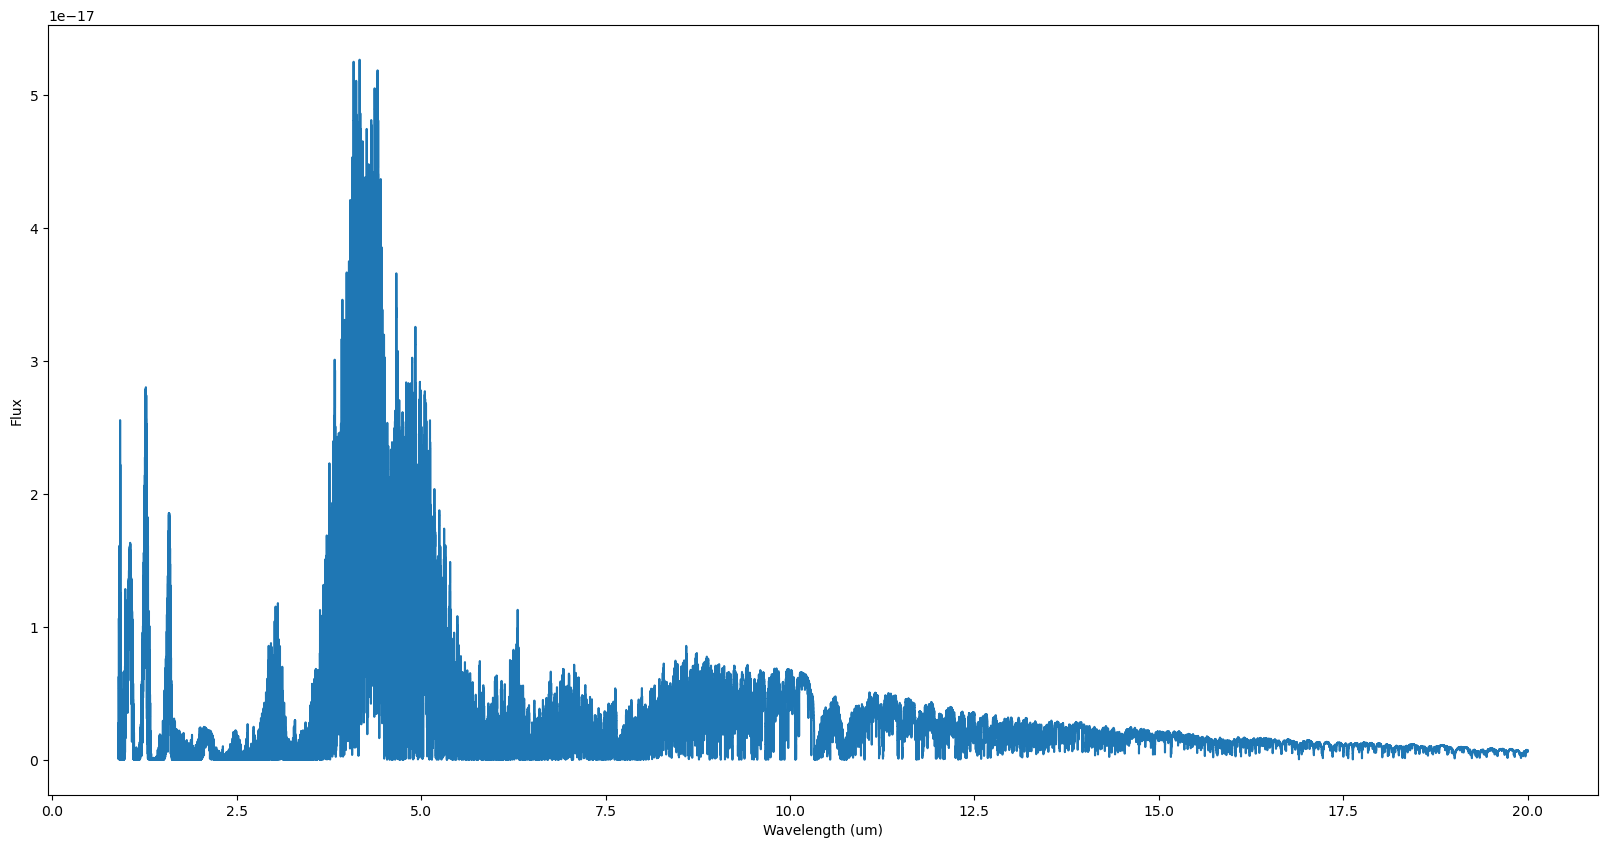

In [22]:
fig, ax_mod = plt.subplots(figsize=(20, 10))
ax_mod.step(modspec[0, :],modspec[1, :])
ax_mod.set_xlabel('Wavelength (um)')
ax_mod.set_ylabel('Flux')
plt.show()

In [23]:
R = obspec[-1, :]
modspec = conv_non_uniform_R(obspec, shiftspec, R)

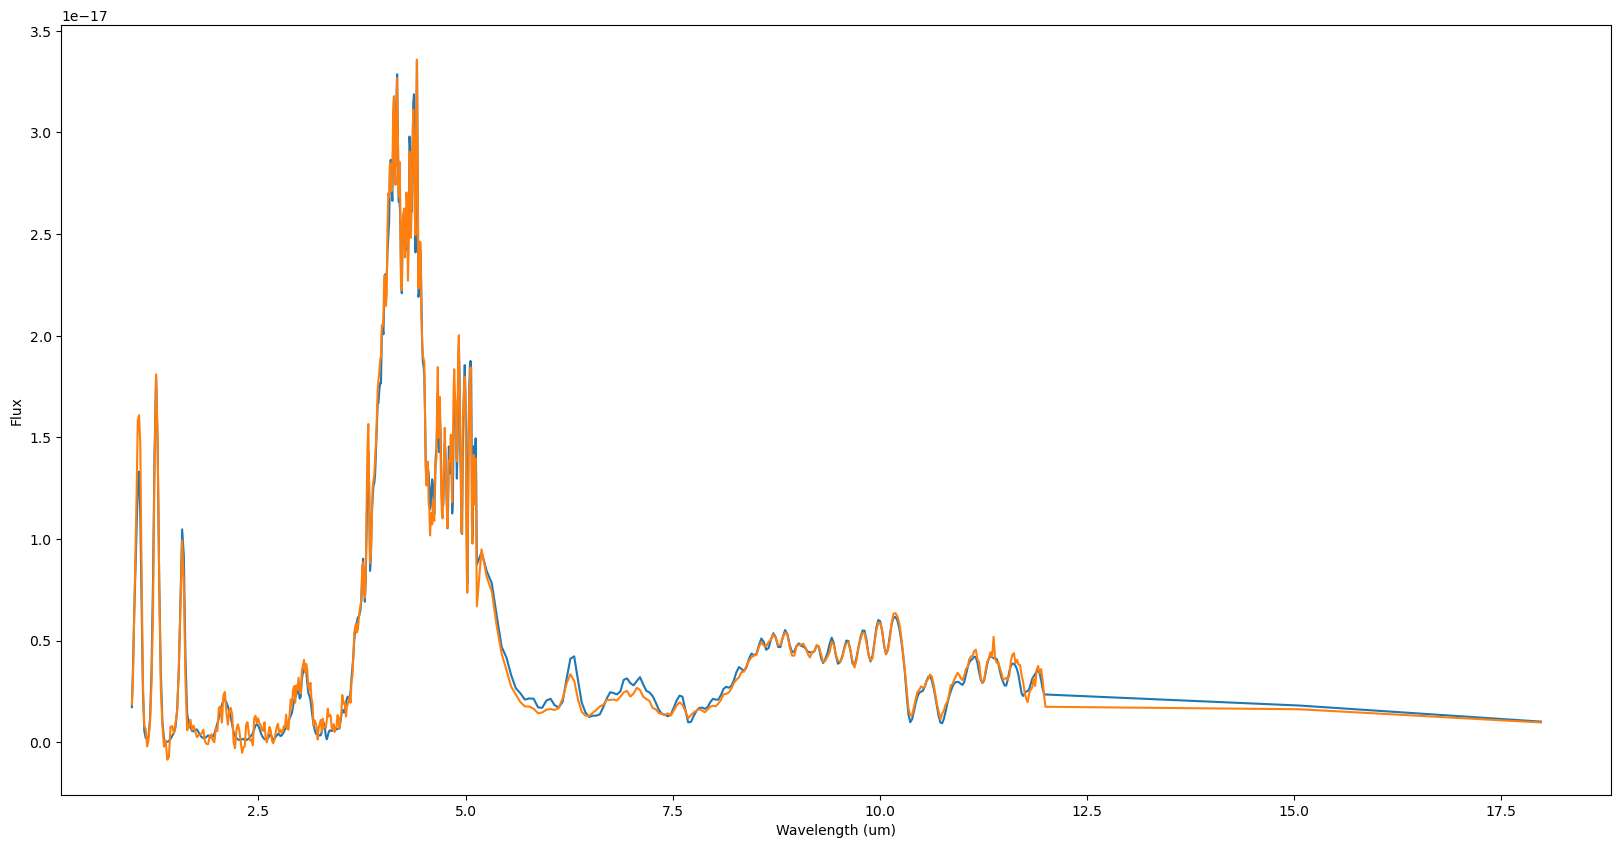

In [24]:
fig, ax_mod = plt.subplots(figsize=(20, 10))
ax_mod.plot(obspec[0,:],modspec)
ax_mod.plot(obspec[0, :],obspec[1, :])
ax_mod.set_xlabel('Wavelength (um)')
ax_mod.set_ylabel('Flux')
#plt.legend()
plt.show()

In [26]:
np.where(shiftspec[0, :] < 5.2)[0][0]

13472

In [27]:
modspec

array([[9.00043056e-01, 9.00133060e-01, 9.00223074e-01, ...,
        1.99960006e+01, 1.99980002e+01, 2.00000000e+01],
       [9.56235530e-19, 3.64354438e-19, 1.73312691e-19, ...,
        6.17567714e-19, 5.69852017e-19, 7.05951155e-19]])

In [35]:
mr_NIRSpec = np.where(modspec[0, :] < wavelength_cutoff)[0]
or_NIRSpec = np.where(obspec[0, :] < wavelength_cutoff)[0]

mr_MIRI = np.where(np.logical_and(modspec[0, :] > wavelength_cutoff, modspec[0, :] < 13.0))[0]
or_MIRI = np.where(np.logical_and(obspec[0, :] > wavelength_cutoff, obspec[0, :] < 13.0))[0]

R = obspec[-1, :]

NIRSpec = 1 * conv_non_uniform_R(obspec[:, or_NIRSpec], modspec[:, mr_NIRSpec], R[or_NIRSpec])
MIRI = 1 * conv_non_uniform_R(obspec[:, or_MIRI], modspec[:, mr_MIRI], R[or_MIRI])

In [37]:
np.where(np.logical_and(obspec[0, :] > wavelength_cutoff, obspec[0, :] < 13.0))[0]

array([342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354,
       355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367,
       368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
       381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
       394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406,
       407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
       420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432,
       433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445,
       446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458,
       459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471,
       472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484,
       485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497,
       498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510,
       511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 52

In [40]:
obspec[0, -2:]

array([15.065, 17.987])

In [43]:
mr_photometry = np.where(modspec[0, :] > 13)[0]
or_photometry = np.where(obspec[0, :] > 13)[0]

In [44]:
conv_non_uniform_R(obspec[:, or_photometry], modspec[:, mr_photometry], R[or_photometry])

array([1.80353551e-18, 1.01090191e-18])